### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


Let's use some of the code from the seminar!

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
217082,72248936,Quality Documentation Engineer,Title: Quality Engineer Documentation My clien...,"Rotherham,Barnsley,Doncaster,Sheffield,Wakefie...",UK,NaN,permanent,Kinetic Yorkshire Skilled Trades,Manufacturing Jobs,21k pa + benefits,21000,jobsite.co.uk,9.952325
189522,71713073,Global Medical Affairs Director Oncology (UK),In this challenging role you will be responsib...,"England,Uk,East Sussex,Surrey,Cambridge,London",London,NaN,permanent,Barrington James Ltd,Healthcare & Nursing Jobs,75k - 90k,82500,emedcareers.com,11.320565
38336,68305656,Care Assistant Ware,Site or Unit : Highfield Care Home Address : *...,Ware,Ware,full_time,NaN,Four Seasons Health Care,Healthcare & Nursing Jobs,6.69 - 6.89/Hour,13036,staffnurse.com,9.475547


In [7]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

def tokenize_join(x):
    return " ".join(tokenizer.tokenize(str(x).lower()))

data["Title"] = data["Title"].apply(tokenize_join)
data["FullDescription"] = data["FullDescription"].apply(tokenize_join)

In [8]:
from collections import Counter
token_counts = Counter()

for line in data["Title"].values:
    token_counts.update(line.split())

for line in data["FullDescription"].values:
    token_counts.update(line.split())

In [9]:
min_count = 10

tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [11]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [12]:
from sklearn.feature_extraction import DictVectorizer

top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

device

'cuda'

#### A) CNN architecture

In [36]:
class TitleEncoder(nn.Module):
  def __init__(self, n_parallel_conv=1, kernel_sizes=None):
    super().__init__()
    if kernel_sizes is None:
      kernel_sizes = [3] * n_parallel_conv
    assert isinstance(kernel_sizes, (list, tuple)) and all(isinstance(k, (int, float)) for k in kernel_sizes), "Kernel_sizes is a list of numbers"
    assert len(kernel_sizes) == n_parallel_conv, "Kernel_sizes length == n_parallel_conv"
    self.emb = nn.Embedding(len(tokens), 32)
    self.convs = nn.ModuleList([
        nn.Conv1d(32, 64, kernel_size=(k,)) for k in kernel_sizes
    ])

  def forward(self, title_idx):
    conv = torch.cat(
        [conv(self.emb(title_idx).swapaxes(1, 2))
        for conv in self.convs],
        dim=2)
    return conv.max(dim=-1).values


class SalaryPredictor(nn.Module):
  def __init__(
      self,
      n_tokens=len(tokens),
      n_cat_features=len(categorical_vectorizer.vocabulary_),
      hid_size=64,
      use_dropout=False,
      dropout_rate=0.5,
      use_batch_norm=False,
      n_additional_layers=0,
      **text_encoder_kwargs
  ):
    super().__init__()
    self.title_enc = TitleEncoder(**text_encoder_kwargs)
    self.desc_enc = TitleEncoder(**text_encoder_kwargs)
    layer = nn.Sequential(
        nn.Linear(hid_size, hid_size),
        nn.ReLU()
    )
    self.cat_enc = nn.Sequential(
        nn.Linear(n_cat_features, hid_size),
        nn.Dropout(dropout_rate) if use_dropout else nn.Identity(),
        nn.ReLU(),
        nn.BatchNorm1d(hid_size) if use_batch_norm else nn.Identity(),
        *[layer for _ in range(n_additional_layers)]
    )
    self.output_layers = nn.Sequential(
        nn.Linear(hid_size * 3, hid_size),
        nn.Dropout(dropout_rate) if use_dropout else nn.Identity(),
        nn.ReLU(),
        nn.BatchNorm1d(hid_size) if use_batch_norm else nn.Identity(),
        *[layer for _ in range(n_additional_layers)],
        nn.Linear(hid_size, 1),
        nn.Dropout(dropout_rate) if use_dropout else nn.Identity(),
        nn.ReLU()
    )


  def forward(self, batch):
    title = self.title_enc(batch["Title"])
    desc = self.desc_enc(batch["FullDescription"])
    cat = self.cat_enc(batch["Categorical"])
    combined = torch.cat([title, desc, cat], dim=1)
    return self.output_layers(combined).squeeze()


In [20]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 5

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean absolute error: %.5f" % mae)
    return mae

In [37]:
baseline_model = SalaryPredictor().to(device)
parallel_conv_model = SalaryPredictor(n_parallel_conv=3, kernel_sizes=[3, 4, 5]).to(device)
dropout_model = SalaryPredictor(use_dropout=True).to(device)
batch_norm_model = SalaryPredictor(use_batch_norm=True).to(device)
additional_layers_model = SalaryPredictor(n_additional_layers=3).to(device)

criterion = nn.MSELoss(reduction='sum')

In [22]:
def train_model(name, model, optimizer=None):
    print(name)
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
    loss_track = []
    mae_track = []
    for epoch in range(EPOCHS):
        loss_over_epoch = []
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm(enumerate(
                iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
                total=len(data_train) // BATCH_SIZE
        ):
            pred = model(batch)
            loss = criterion(pred, batch[TARGET_COLUMN])
            optimizer.zero_grad()
            loss.backward()

            loss_over_epoch.append(loss.detach().cpu())

            optimizer.step()

        loss_track.append(np.mean(loss_over_epoch))
        mae = print_metrics(model, data_val, device=device)
        mae_track.append(mae)
    return loss_track, mae_track

In [23]:
baseline_loss, baseline_mae = train_model("BASELINE", baseline_model)

BASELINE
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.23705
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.20790
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.24960
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.18604
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.18612


In [24]:
parallel_conv_loss, parallel_conv_mae = train_model("PARALLEL CONV", parallel_conv_model)

PARALLEL CONV
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.30138
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.19819
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.21374
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.19504
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.18507


In [25]:
dropout_loss, dropout_mae = train_model("DROPOUT", dropout_model)

DROPOUT
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 5.10140
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 5.14419
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 10.31785
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 10.31785
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 10.31785


In [31]:
batch_norm_loss, batch_norm_mae = train_model("BATCH NORM", batch_norm_model)

BATCH NORM
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.34257
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.19155
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.24729
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.18079
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.25860


In [38]:
add_layers_loss, add_layers_mae = train_model("ADD LAYERS", additional_layers_model)

ADD LAYERS
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.61010
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.54916
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.39520
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.39673
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.39495


#### C) Fun with words

In [39]:
import gensim.downloader as api

embeddings = api.load('glove-wiki-gigaword-300')
embedding_size = embeddings.vector_size

[==================================================] 100.0% 376.1/376.1MB downloaded


In [49]:
embeddings_matrix = []

for token in token_to_id:
  if token in embeddings:
    embeddings_matrix.append(embeddings.get_vector(token))
  else:
    embeddings_matrix.append(np.zeros(embedding_size))

embeddings_matrix = torch.tensor(np.array(embeddings_matrix)).to(device)

In [60]:
class GensimEncoder(nn.Module):
  def __init__(
      self,
      vocab_size=len(token_to_id),
      embeddings_matrix=embeddings_matrix,
      embedding_size=embedding_size
  ):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, embedding_size)
    self.emb.weight.data.copy_(embeddings_matrix)
    self.emb.weight.requires_grad = True
    self.conv1 = nn.Conv1d(embedding_size, embedding_size * 2, kernel_size=3)

  def forward(self, title_idx):
    return self.conv1(
        self.emb(title_idx).swapaxes(1, 2)
    ).max(dim=-1).values


class SalaryPredictorGensim(SalaryPredictor):
  def __init__(self):
    super().__init__(hid_size=embedding_size * 2)
    self.title_enc = GensimEncoder()
    self.desc_enc = self.title_enc


In [61]:
gensim_model = SalaryPredictorGensim().to(device)

optimizer = torch.optim.Adam(gensim_model.parameters(), lr=1e-3, weight_decay=1e-5)

gensim_loss, gensim_mae = train_model("GENSIM", gensim_model, optimizer)

GENSIM
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.25347
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.28483
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.26059
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.24750
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.22961


####D) Going recurrent

In [62]:
class SalaryPredictorRNN(nn.Module):
  def __init__(
      self,
      n_tokens=len(tokens),
      n_cat_features=len(categorical_vectorizer.vocabulary_),
      hid_size=64
  ):
      super().__init__()
      self.title_emb = nn.Embedding(n_tokens, 32)
      self.desc_emb = nn.Embedding(n_tokens, 32)

      self.conv = nn.Conv1d(32, hid_size, kernel_size=3)

      self.title_lstm = nn.LSTM(32, hid_size, bidirectional=True, batch_first=True)
      self.desc_lstm = nn.LSTM(hid_size, hid_size, bidirectional=True, batch_first=True)

      self.cat_enc = nn.Sequential(
          nn.Linear(n_cat_features, hid_size),
          nn.ReLU()
      )

      self.output_layers = nn.Sequential(
          nn.Linear(hid_size * 5, hid_size),
          nn.ReLU(),
          nn.Linear(hid_size, 1),
          nn.ReLU()
      )

  def forward(self, batch):
      title_emb = self.title_emb(batch["Title"])
      title_lstm, _ = self.title_lstm(title_emb)

      title_pooled = title_lstm.swapaxes(1, 2).max(dim=-1).values

      desc_emb = self.desc_emb(batch["FullDescription"])

      desc_conv = self.conv(desc_emb.swapaxes(1, 2)).swapaxes(1, 2)

      desc_lstm, _ = self.desc_lstm(desc_conv)

      desc_pooled = desc_lstm.swapaxes(1, 2).max(dim=-1).values

      categorical = self.cat_enc(batch["Categorical"])
      concat = torch.cat([title_pooled, desc_pooled, categorical], dim=-1)
      return self.output_layers(concat).squeeze()

In [63]:
rnn_model = SalaryPredictorRNN().to(device)

rnn_loss, rnn_mae = train_model("RNN", rnn_model)

RNN
epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.20002
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.28759
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.23252
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.26120
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean absolute error: 0.19998


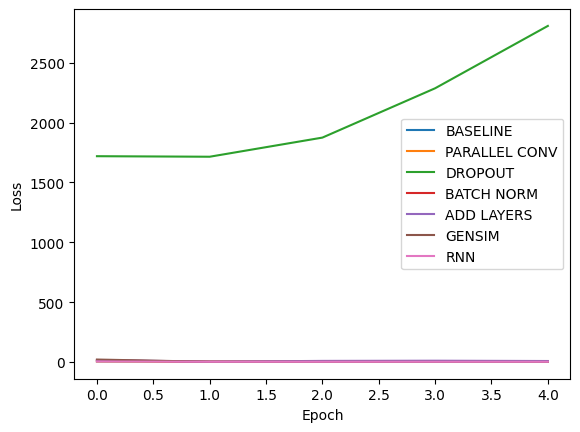

In [64]:
plt.plot(baseline_loss, label="BASELINE")
plt.plot(parallel_conv_loss, label="PARALLEL CONV")
plt.plot(dropout_loss, label="DROPOUT")
plt.plot(batch_norm_loss, label="BATCH NORM")
plt.plot(add_layers_loss, label="ADD LAYERS")
plt.plot(gensim_loss, label="GENSIM")
plt.plot(rnn_loss, label="RNN")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

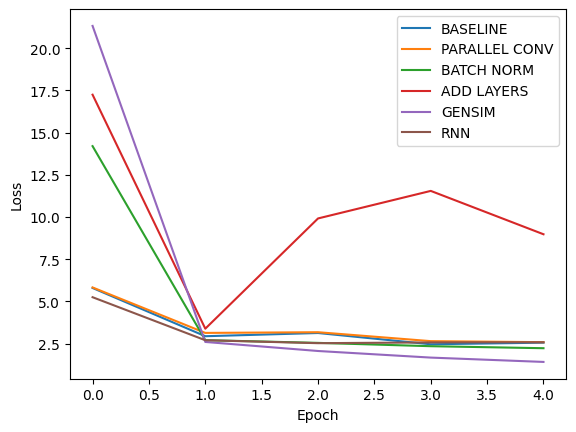

In [65]:
# without dropout
plt.plot(baseline_loss, label="BASELINE")
plt.plot(parallel_conv_loss, label="PARALLEL CONV")
plt.plot(batch_norm_loss, label="BATCH NORM")
plt.plot(add_layers_loss, label="ADD LAYERS")
plt.plot(gensim_loss, label="GENSIM")
plt.plot(rnn_loss, label="RNN")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

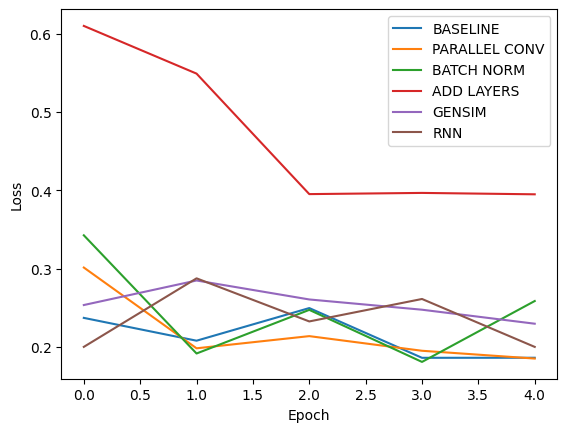

In [67]:
plt.plot(baseline_mae, label="BASELINE")
plt.plot(parallel_conv_mae, label="PARALLEL CONV")
plt.plot(batch_norm_mae, label="BATCH NORM")
plt.plot(add_layers_mae, label="ADD LAYERS")
plt.plot(gensim_mae, label="GENSIM")
plt.plot(rnn_mae, label="RNN")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### A short report

Please tell us what you did and how did it work.

#### A) CNN architecture
I have implemented all the suggested tricks in this section.
All of them worked longer than baseline.
1. Dropout showed the worst results(and worse than baseline). I guess this method is not well suited for regression tasks.
2. Batch Norm. Made good results on some epochs.
3. Parallel convolution layers. I used different kernel size for convolutions. This modification slightly improved baseline results.
4. Adding dense layers suddenly turned out to be worse than the baseline.

Maybe they need more epochs. It also made sense to test them on a larger batchsize

#### C) Fun with words
I used 'glove-wiki-gigaword-300' embeddings from gensim.
I also used another optimizer, because it needs to prevent overfitting on this pretrained embaddings.
It worked much longer than previous modifications. The model is learning well, but MAE is worse than baseline :( Maybe new learning rate is too small...

#### D) Going recurrent
All previous conclusions can be attributed to this model, which for some reason also showed MAE worse than baseline.

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!